In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pickle
import os
import warnings
import matplotlib.pyplot as plt
# Dependency imports
from absl import flags
import matplotlib
%matplotlib inline
matplotlib.use("Agg")
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.contrib.learn.python.learn.datasets import mnist

# TODO(b/78137893): Integration tests currently fail with seaborn imports.
warnings.simplefilter(action="ignore")

try:
  import seaborn as sns  # pylint: disable=g-import-not-at-top
  HAS_SEABORN = True
except ImportError:
  HAS_SEABORN = False

tfd = tfp.distributions

IMAGE_SHAPE = [28, 28, 1]

flags.DEFINE_float("learning_rate",
                   default=0.001,
                   help="Initial learning rate.")
flags.DEFINE_integer("max_steps",
                     default=300,
                     help="Number of training steps to run.")
flags.DEFINE_integer("batch_size",
                     default=128,
                    help="Batch size.")

#flags.DEFINE_integer("batch_size",
#                     default=1024,
#                     help="Batch size.")


flags.DEFINE_string("data_dir",
                    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                                         "bayesian_neural_network/data"),
                    help="Directory where data is stored (if using real data).")
flags.DEFINE_string(
    "model_dir",
    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                         "bayesian_neural_network/"),
    help="Directory to put the model's fit.")
flags.DEFINE_integer("viz_steps",
                     default=100,
                     help="Frequency at which save visualizations.")
flags.DEFINE_integer("num_monte_carlo",
                     default=50,
                     help="Network draws to compute predictive probabilities.")
flags.DEFINE_bool("fake_data",
                  default=None,
                  help="If true, uses fake data. Defaults to real data.")

flags.DEFINE_integer(
    "mixture_components",
    default=10,
    help="Number of mixture components to use in the prior. Each component is "
         "a diagonal normal distribution. The parameters of the components are "
         "intialized randomly, and then learned along with the rest of the "
         "parameters. If `analytic_kl` is True, `mixture_components` must be "
         "set to `1`.")
flags.DEFINE_bool(
    "analytic_kl",
    default=False,
    help="Whether or not to use the analytic version of the KL. When set to "
         "False the E_{Z~q(Z|X)}[log p(Z)p(X|Z) - log q(Z|X)] form of the ELBO "
         "will be used. Otherwise the -KL(q(Z|X) || p(Z)) + "
         "E_{Z~q(Z|X)}[log p(X|Z)] form will be used. If analytic_kl is True, "
         "then you must also specify `mixture_components=1`.")

FLAGS = flags.FLAGS
import sys
FLAGS(sys.argv, known_only=True)

/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel_launcher.py',
 '-f',
 '/Users/karimimohammedbelhal/Library/Jupyter/runtime/kernel-3bbd9680-55ea-468c-8641-4f537b383727.json']

In [2]:
def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
  """Save a PNG plot with histograms of weight means and stddevs.
  Args:
    names: A Python `iterable` of `str` variable names.
    qm_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior means of weight varibles.
    qs_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior standard deviations of weight varibles.
    fname: Python `str` filename to save the plot to.
  """
  fig = figure.Figure(figsize=(6, 3))
  canvas = backend_agg.FigureCanvasAgg(fig)

  ax = fig.add_subplot(1, 2, 1)
  for n, qm in zip(names, qm_vals):
    sns.distplot(qm.flatten(), ax=ax, label=n)
  ax.set_title("weight means")
  ax.set_xlim([-1.5, 1.5])
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  for n, qs in zip(names, qs_vals):
    sns.distplot(qs.flatten(), ax=ax)
  ax.set_title("weight stddevs")
  ax.set_xlim([0, 1.])

  fig.tight_layout()
  canvas.print_figure(fname, format="png")
  print("saved {}".format(fname))


def plot_heldout_prediction(input_vals, probs,
                            fname, n=10, title=""):
    """Save a PNG plot visualizing posterior uncertainty on heldout data.
  Args:
    input_vals: A `float`-like Numpy `array` of shape
      `[num_heldout] + IMAGE_SHAPE`, containing heldout input images.
    probs: A `float`-like Numpy array of shape `[num_monte_carlo,
      num_heldout, num_classes]` containing Monte Carlo samples of
      class probabilities for each heldout sample.
    fname: Python `str` filename to save the plot to.
    n: Python `int` number of datapoints to vizualize.
    title: Python `str` title for the plot.
  """
    fig = figure.Figure(figsize=(9, 3*n))
    canvas = backend_agg.FigureCanvasAgg(fig)
    for i in range(n):
        ax = fig.add_subplot(n, 3, 3*i + 1)
        ax.imshow(input_vals[i, :].reshape(IMAGE_SHAPE[:-1]), interpolation="None")

        ax = fig.add_subplot(n, 3, 3*i + 2)
        for prob_sample in probs:
            sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
            ax.set_ylim([0, 1])
            ax.set_title("posterior samples")

        ax = fig.add_subplot(n, 3, 3*i + 3)
        sns.barplot(np.arange(10), np.mean(probs[:, i, :], axis=0), ax=ax)
        ax.set_ylim([0, 1])
        ax.set_title("predictive probs")
        
    fig.suptitle(title)
    fig.tight_layout()

    canvas.print_figure(fname, format="png")
    print("saved {}".format(fname))


def build_input_pipeline(mnist_data, batch_size, heldout_size):
    """Build an Iterator switching between train and heldout data."""

    # Build an iterator over training batches.
    training_dataset = tf.data.Dataset.from_tensor_slices(
      (mnist_data.train.images, np.int32(mnist_data.train.labels)))
    training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
    training_iterator = training_batches.make_one_shot_iterator()

    # Build a iterator over the heldout set with batch_size=heldout_size,
    # i.e., return the entire heldout set as a constant.
    heldout_dataset = tf.data.Dataset.from_tensor_slices(
      (mnist_data.validation.images,
       np.int32(mnist_data.validation.labels)))
    heldout_frozen = (heldout_dataset.take(heldout_size).
                    repeat().batch(heldout_size))
    heldout_iterator = heldout_frozen.make_one_shot_iterator()

    # Combine these into a feedable iterator that can switch between training
    # and validation inputs.
    handle = tf.placeholder(tf.string, shape=[])
    feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
    images, labels = feedable_iterator.get_next()

    return images, labels, handle, training_iterator, heldout_iterator


def build_fake_data(num_examples=10):
  """Build fake MNIST-style data for unit testing."""

  class Dummy(object):
    pass

  num_examples = 10
  mnist_data = Dummy()
  mnist_data.train = Dummy()
  mnist_data.train.images = np.float32(np.random.randn(
      num_examples, *IMAGE_SHAPE))
  mnist_data.train.labels = np.int32(np.random.permutation(
      np.arange(num_examples)))
  mnist_data.train.num_examples = num_examples
  mnist_data.validation = Dummy()
  mnist_data.validation.images = np.float32(np.random.randn(
      num_examples, *IMAGE_SHAPE))
  mnist_data.validation.labels = np.int32(np.random.permutation(
      np.arange(num_examples)))
  mnist_data.validation.num_examples = num_examples
  return mnist_data


In [3]:
tf.gfile.MakeDirs(FLAGS.model_dir)
mnist_data = mnist.read_data_sets(FLAGS.data_dir, reshape=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/bayesian_neural_network/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/bayesian_neural_network/data/train-labels-idx1-ubyte.gz
Extracting /tmp/bayesian_neural_network/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/bayesian_neural_network/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
(images, labels, handle,
   training_iterator, heldout_iterator) = build_input_pipeline(
       mnist_data, FLAGS.batch_size, mnist_data.validation.num_examples)

with tf.name_scope("bayesian_neural_net", values=[images]):
    neural_net = tf.keras.Sequential([
        tfp.layers.Convolution2DFlipout(6,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                     strides=[2, 2],
                                     padding="SAME"),
        tfp.layers.Convolution2DFlipout(16,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                     strides=[2, 2],
                                     padding="SAME"),
        tfp.layers.Convolution2DFlipout(120,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.Flatten(),
        tfp.layers.DenseFlipout(84, activation=tf.nn.relu),
        tfp.layers.DenseFlipout(10)
        ])

    logits = neural_net(images)
    labels_distribution = tfd.Categorical(logits=logits)


### Flipout MC estimator

In [ ]:
with tf.name_scope("bayesian_neural_net", values=[images]):
    neural_net = tf.keras.Sequential([
        tfp.layers.Convolution2DFlipout(6,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                     strides=[2, 2],
                                     padding="SAME"),
        tf.keras.layers.Flatten(),
        tfp.layers.DenseFlipout(84, activation=tf.nn.relu),
        tfp.layers.DenseFlipout(10)
        ])

    logits = neural_net(images)
    labels_distribution = tfd.Categorical(logits=logits)

### Reparametrization trick Estimator (BBB)

In [ ]:
with tf.name_scope("bayesian_neural_net", values=[images]):
    neural_net = tf.keras.Sequential([
        tfp.layers.Convolution2DReparameterization(6,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                     strides=[2, 2],
                                     padding="SAME"),
        tf.keras.layers.Flatten(),
        tfp.layers.DenseReparameterization(84, activation=tf.nn.relu),
        tfp.layers.DenseReparameterization(10)
        ])

    logits = neural_net(images)
    labels_distribution = tfd.Categorical(logits=logits)

#Loss
neg_log_likelihood = -tf.reduce_mean(labels_distribution.log_prob(labels))
kl = sum(neural_net.losses) / mnist_data.train.num_examples
elbo_loss = neg_log_likelihood + kl

#Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate)
train_op = optimizer.minimize(elbo_loss)

In [6]:
with tf.name_scope("bayesian_neural_net", values=[images]):
    neural_net = tf.keras.Sequential([
        tfp.layers.Convolution2DReparameterization(6,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                     strides=[2, 2],
                                     padding="SAME"),
        tf.keras.layers.Flatten(),
        tfp.layers.DenseReparameterization(84, activation=tf.nn.relu),
        tfp.layers.DenseReparameterization(10)
        ])

    logits = neural_net(images)
    labels_distribution = tfd.Categorical(logits=logits)

In [7]:
neg_log_likelihood = -tf.reduce_mean(labels_distribution.log_prob(labels))
kl = sum(neural_net.losses) / mnist_data.train.num_examples
elbo_loss = neg_log_likelihood + kl

# Build metrics for evaluation. Predictions are formed from a single forward
# pass of the probabilistic layers. They are cheap but noisy predictions.
predictions = tf.argmax(logits, axis=1)
accuracy, accuracy_update_op = tf.metrics.accuracy(
      labels=labels, predictions=predictions)

# ADAM

In [27]:
names = []
qmeans = []
qstds = []
for i, layer in enumerate(neural_net.layers):
    try:
        q = layer.kernel_posterior
    except AttributeError:
        continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)
    train_op = optimizer.minimize(elbo_loss)

init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())

In [28]:
sess = tf.Session()

In [29]:
lossadam = []

In [30]:
sess.run(init_op)

# Run the training loop.
train_handle = sess.run(training_iterator.string_handle())
heldout_handle = sess.run(heldout_iterator.string_handle())
#for step in range(FLAGS.max_steps):
for step in range(1000):
    _ = sess.run([train_op, accuracy_update_op],
                   feed_dict={handle: train_handle})
    if step % 100 == 0:
        loss_value, accuracy_value = sess.run(
            [elbo_loss, accuracy], feed_dict={handle: train_handle})
        lossadam.append(loss_value)
        print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(
            step, loss_value, accuracy_value))

Step:   0 Loss: 6.981 Accuracy: 0.102
Step: 100 Loss: 5.157 Accuracy: 0.571
Step: 200 Loss: 4.995 Accuracy: 0.689
Step: 300 Loss: 4.618 Accuracy: 0.747
Step: 400 Loss: 4.617 Accuracy: 0.781
Step: 500 Loss: 4.598 Accuracy: 0.804
Step: 600 Loss: 4.367 Accuracy: 0.822
Step: 700 Loss: 4.310 Accuracy: 0.835
Step: 800 Loss: 4.203 Accuracy: 0.847
Step: 900 Loss: 4.217 Accuracy: 0.856


In [31]:
with open('losses/adamloss', 'wb') as fp:
    pickle.dump(lossadam, fp)

# BBB

In [32]:
names = []
qmeans = []
qstds = []
for i, layer in enumerate(neural_net.layers):
    try:
        q = layer.kernel_posterior
    except AttributeError:
        continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(elbo_loss)

init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())
sess = tf.Session()
losssgd = []

In [33]:
sess.run(init_op)

# Run the training loop.
train_handle = sess.run(training_iterator.string_handle())
heldout_handle = sess.run(heldout_iterator.string_handle())
#for step in range(FLAGS.max_steps):
for step in range(1000):
    _ = sess.run([train_op, accuracy_update_op],
                   feed_dict={handle: train_handle})
    if step % 100 == 0:
        loss_value, accuracy_value = sess.run(
            [elbo_loss, accuracy], feed_dict={handle: train_handle})
        losssgd.append(loss_value)
        print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(
            step, loss_value, accuracy_value))

Step:   0 Loss: 6.924 Accuracy: 0.117
Step: 100 Loss: 5.074 Accuracy: 0.599
Step: 200 Loss: 5.098 Accuracy: 0.720
Step: 300 Loss: 4.984 Accuracy: 0.773
Step: 400 Loss: 4.965 Accuracy: 0.805
Step: 500 Loss: 4.829 Accuracy: 0.827
Step: 600 Loss: 4.847 Accuracy: 0.843
Step: 700 Loss: 4.830 Accuracy: 0.855
Step: 800 Loss: 4.794 Accuracy: 0.865
Step: 900 Loss: 4.748 Accuracy: 0.874


In [34]:
with open('losses/bbbloss', 'wb') as fp:
    pickle.dump(losssgd, fp)

# MISSO

In [23]:
names = []
qmeans = []
qstds = []
for i, layer in enumerate(neural_net.layers):
    try:
        q = layer.kernel_posterior
    except AttributeError:
        continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate)
    train_op = optimizer.minimize(elbo_loss)

init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())
t_vars = tf.trainable_variables()
sess = tf.Session()
lossmisso = []

In [24]:
def _compute_gradients(tensor, var_list):
  grads = tf.gradients(tensor, var_list)
  return [grad if grad is not None else tf.zeros_like(var)
          for var, grad in zip(var_list, grads)]

In [25]:
#First pass over the data with SGD (keeping in memory all the gradients)
sess.run(init_op)
n_batches = 100
gradients = []
train_handle = sess.run(training_iterator.string_handle())
heldout_handle = sess.run(heldout_iterator.string_handle())
for _ in xrange(n_batches):
    print(_)
    X_batch, Y_batch =  mnist_data.train.next_batch(FLAGS.batch_size, fake_data=False)
    grads = _compute_gradients(elbo_loss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(FLAGS.learning_rate * grad))
    train_op = tf.group(*var_updates)
    gradients.append(grads)
    sess.run([train_op, accuracy_update_op],
                   feed_dict={handle: train_handle})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


Exception KeyboardInterrupt: KeyboardInterrupt() in <bound method Session.__del__ of <tensorflow.python.client.session.Session object at 0x103aec890>> ignored


KeyboardInterrupt: 

In [22]:
# Run the training loop.
train_handle = sess.run(training_iterator.string_handle())
heldout_handle = sess.run(heldout_iterator.string_handle())

for epoch in range(100):
    for i in range(n_batches):
        X_batch, Y_batch =  mnist_data.train.next_batch(FLAGS.batch_size, fake_data=False)
        grads = _compute_gradients(elbo_loss, tf.trainable_variables())
        gradients[i] = grads
        var_updates = []
        var_list = tf.trainable_variables()
        for gradstemp in gradients:
            for grad, var in zip(gradstemp, var_list):
                var_updates.append(var.assign_sub(FLAGS.learning_rate * grad))
        train_op = tf.group(*var_updates)
        _ = sess.run([train_op, accuracy_update_op],
                   feed_dict={handle: train_handle})
        
    if epoch % 1 == 0:
        loss_value, accuracy_value = sess.run(
            [elbo_loss, accuracy], feed_dict={handle: train_handle})
        lossmisso.append(loss_value)
        print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(
            epoch, loss_value, accuracy_value))

Step:   0 Loss: 6.959 Accuracy: 0.083
Step:   1 Loss: 7.264 Accuracy: 0.094
Step:   2 Loss: 7.201 Accuracy: 0.101
Step:   3 Loss: 6.890 Accuracy: 0.104
Step:   4 Loss: 6.878 Accuracy: 0.108
Step:   5 Loss: 7.040 Accuracy: 0.108
Step:   6 Loss: 7.113 Accuracy: 0.110
Step:   7 Loss: 7.101 Accuracy: 0.111
Step:   8 Loss: 6.948 Accuracy: 0.112
Step:   9 Loss: 7.010 Accuracy: 0.113
Step:  10 Loss: 6.969 Accuracy: 0.117
Step:  11 Loss: 6.839 Accuracy: 0.117
Step:  12 Loss: 7.002 Accuracy: 0.118
Step:  13 Loss: 6.999 Accuracy: 0.116
Step:  14 Loss: 6.960 Accuracy: 0.118
Step:  15 Loss: 6.900 Accuracy: 0.119
Step:  16 Loss: 6.902 Accuracy: 0.117
Step:  17 Loss: 6.792 Accuracy: 0.118
Step:  18 Loss: 6.903 Accuracy: 0.121


KeyboardInterrupt: 

In [26]:
with open('losses/missoloss', 'wb') as fp:
    pickle.dump(lossmisso, fp)

# PLOTS

In [18]:
def display_draws(loss, train_x, EPOCH_NUM):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    plt.plot(np.arange(EPOCH_NUM), loss, label='Train')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Negated ELBO', fontsize=15)
    plt.show()

In [19]:
X_batch, Y_batch = mnist_data.train.next_batch(FLAGS.batch_size)

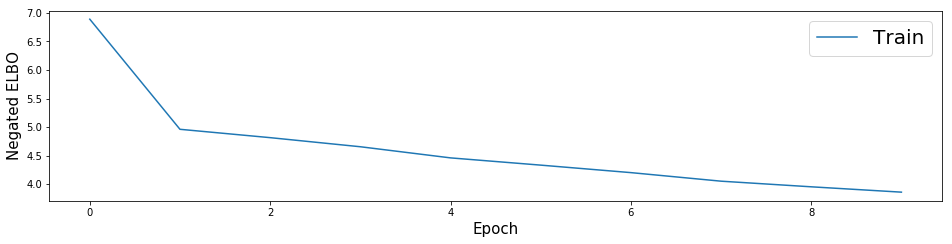

In [41]:
display_draws(lossadam, X_batch, len(lossadam))

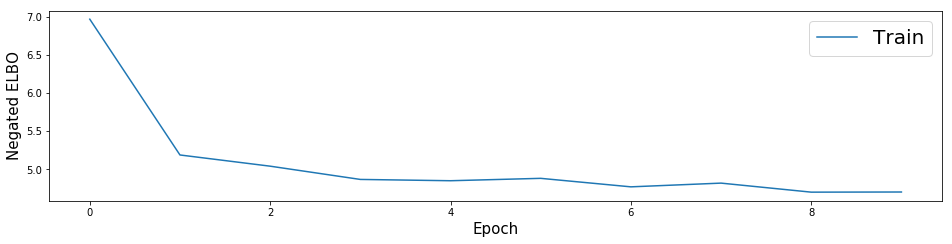

In [35]:
display_draws(losssgd, X_batch, len(losssgd))

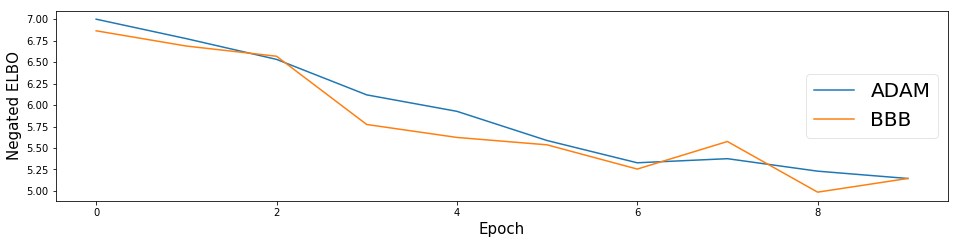

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(len(lossadam)), lossadam, label='ADAM')
plt.plot(np.arange(len(lossadam)), losssgd, label='BBB')
leg = plt.legend(fontsize=20,fancybox=True, loc='right')
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Negated ELBO', fontsize=15)
plt.show()

In [35]:
with open ('losses/bbbloss', 'rb') as fp:
    bbb = pickle.load(fp)
with open ('losses/missoloss', 'rb') as fp:
    misso = pickle.load(fp)
with open ('losses/adamloss', 'rb') as fp:
    adam = pickle.load(fp)

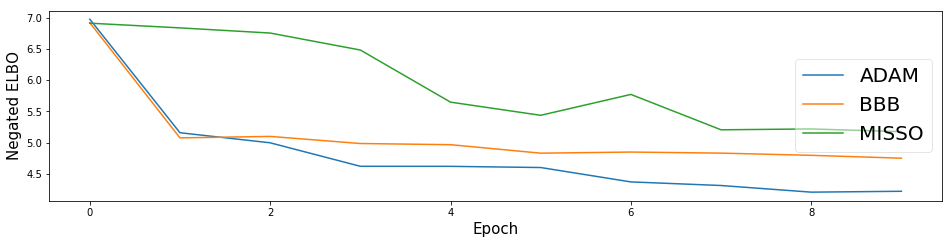

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(len(adam)), lossadam, label='ADAM')
plt.plot(np.arange(len(bbb)), losssgd, label='BBB')
plt.plot(np.arange(len(misso)), lossmisso, label='MISSO')
leg = plt.legend(fontsize=20,fancybox=True, loc='right')
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Negated ELBO', fontsize=15)
plt.show()